In [1]:
!tree -dL 2 input/

input/

0 directories


In [2]:
# generic librairies
import time as time
import numpy as np
import pandas as pd
import gc

# Text librairies
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tag.util import untag
import contractions
# import pycontractions # Alternative better package for removing contractions
from autocorrect import Speller


from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import mglearn
from cycler import cycler

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
#plt.rc('axes', prop_cycle=(
#    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
#    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('precision', 2)

__all__ = ['np', 'mglearn', 'display', 'plt', 'pd']

# Load Data

In [3]:
%%time

# https://numpy.org/devdocs/user/basics.types.html

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str', 'Body': 'str', 'Text': 'str'}

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=['Id', 'Score', 'Title', 'Body','Text'], 
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=10000
                          )

CPU times: user 9.07 ms, sys: 520 µs, total: 9.59 ms
Wall time: 12.8 ms


In [4]:
df_questions

,Id,Score,Body,Title,Text
0,4,718,use change form ' code : trans = 5000 ; this.o...,convert decimal # ?,convert decimal # ? use change form ' code : t...
1,6,305,"absolutely position div contain child , one re...",width collapse percentage width child element ...,width collapse percentage width child element ...
2,7,479,cast like : trans = ( ) trackbar1.value / 5000...,NaN,nan cast like : trans = ( ) trackbar1.value / ...
3,9,2008,"give datetime represent person ' birthday , ag...",calculate someone age base type birthday ?,calculate someone age base type birthday ? giv...
4,11,1576,"give datetime value , display time , like : ho...",calculate time #,"calculate time # give datetime value , display..."
...,...,...,...,...,...
985,2620,1,"security expert , think fact , test security ,...",NaN,"nan security expert , think fact , test securi..."
986,2629,0,"ii , access web.config handle authentication .",NaN,"nan ii , access web.config handle authenticati..."
987,2630,15,"find / software powershell netcmdlets , play l...",favorite powershell cmdlets ?,favorite powershell cmdlets ? find / software ...
988,2639,12,use wordpress blog screwturn wiki ( two separa...,solution ?,solution ? use wordpress blog screwturn wiki (...


In [5]:
text_train = df_questions.Text
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'pandas.core.series.Series'>
length of text_train: 990
text_train[6]:
determine user ' timezone way web server determine user ' timezone within page ? perhaps part string ?


# Representer le texte en "Bag of Words"

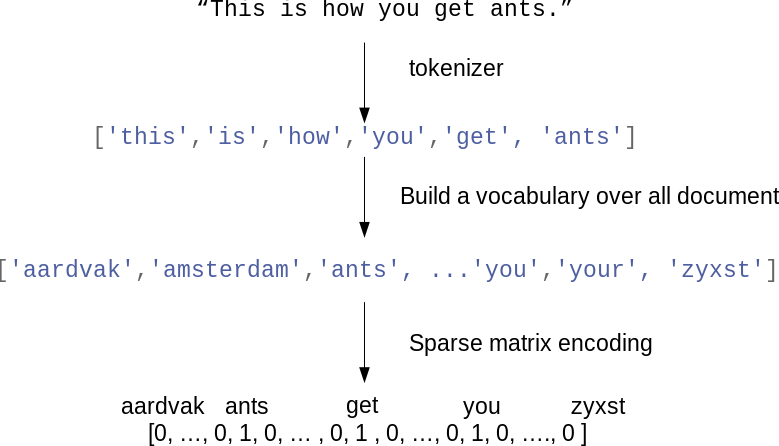

In [6]:
# faire un test de bag of words

bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [8]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [9]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [10]:
print("Dense representation of bag_of_words:\n{}".format(
    bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


## bag-of-words de Post

In [11]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<990x6093 sparse matrix of type '<class 'numpy.int64'>'
	with 31819 stored elements in Compressed Sparse Row format>


In [12]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 5010 to 5030:\n{}".format(feature_names[5010:5030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 6093
First 20 features:
['00', '000', '0000', '0001', '001', '0010', '0011', '002', '002636', '003', '004', '005', '006', '0100', '01010101111', '01267', '0165576136843360246l', '02', '024', '027']
Features 5010 to 5030:
['solution', 'solutions', 'solve', 'somebody', 'someclass', 'somedatastream', 'someeventhandler', 'someeventhandlerdelegate', 'somehow', 'somemethod', 'somemodule', 'someobject', 'someone', 'someotherproduct', 'someparam', 'someparameter', 'somestuff', 'something', 'sometime', 'sometimes']
Every 2000th feature:
['00', 'equation', 'pendingfilerenameoperations', 'worry']


## bag-ofword avec plus d'un mot (n-grams)

In [13]:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [14]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [15]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [16]:
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [17]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


# Modélisation automatique des sujets

## LDA, Latent Dirichlet Allocation
L'objectif de ce type de modélisation de sujets est de récupérer de potentielles catégories pour des traitements ultérieurs. Cette modélisation offre surtout une meilleure compréhension de la structuration du texte en vue de création de features manuelles (mettre l'accent sur certains mots, comprendre ce qui définit une catégorie, etc.)


In [18]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

max_df : float in range [0.0, 1.0] or int, default=1.0
    When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold (corpus-specific
    stop words).

In [19]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                learning_method="online",
                                learning_offset=50.,
                                max_iter=25,
                                random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

In [20]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 6082)


In [21]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

In [22]:
#fonction du livre introduction_to_ml_with_python-master

def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [23]:
# Print out the 10 topics:

print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
proc          memory        color         weight        gcc           
irb           leak          return        div           testwith      
new           process       ago           label         wall          
difference    free          datetime      width         o3            
call          bytearray     delta         id            pitimes       
lambda        marshal       time          window        test          
day           garbage       month         position      fldpi         
124           yourstruct    year          null          atan2         
hello         application   list          dialog        of            
ruby          reference     int           checkbox      define        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
stri

In [24]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

In [25]:
topics = np.array([2,7, 16, 24, 25, 28, 36, 37, 41, 45, 51, 53, 54, 63, 89, 97])

In [26]:
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=8, n_words=10)

topic 2       topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      --------      
xml           data          string        value         int           read          test          return        
csv           handle        time          make          value         value         gcc           proc          
value         structtype    javascript    session       comprehension data          testwith      word          
datetime      byte          function      cookie        bar           byte          return        control       
inside        marshal       quote         net           python        gzip          dialog        browser       
since         try           elem          extend        think         memorystream  wall          letter        
method        struct        parameter     see           compile       buff          o3          

In [27]:
# sort by weight of "function" topic 36
function = np.argsort(document_topics100[:, 63])[::-1]
# print the five documents where the topic is most important
for i in function[:5]:
    # show first two sentences
    print(".".join(text_train[i].split(".")[:2]) + ".\n")

nan make choice server platform base environment , include interface supply . like way windows implement management ii , bad .

nan , think linq really sugar , actually heavily use expression tree -- feature .net .

nan one way decide whether use class think whether class play support role part . exist solely help another class generally make class .

nan link http : //www.whatever.

nan listen podcast scott hanselman morning , talk internationalization , especially really thing , like ( four ' ) thai . also , jeff atwood post :.



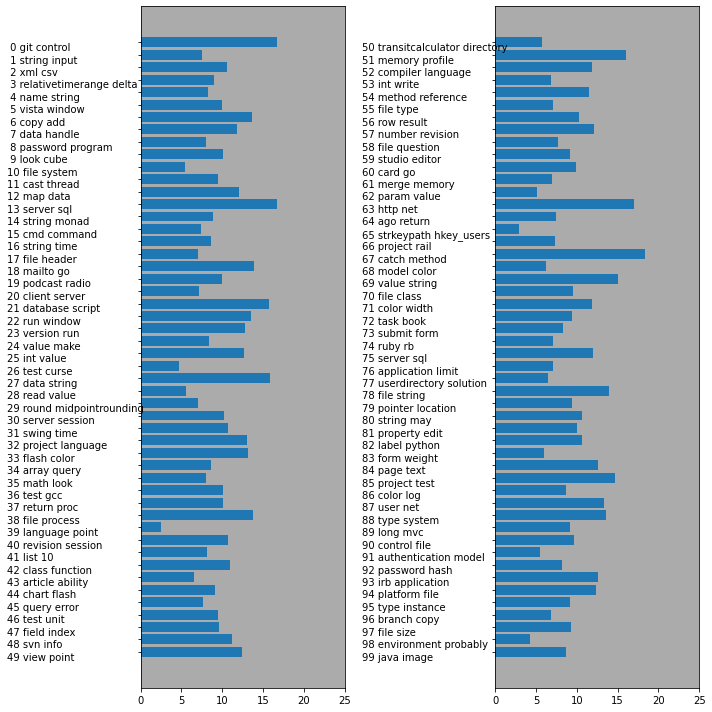

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 25)
    ax[col].patch.set_facecolor('#ababab')
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
fig.patch.set_facecolor('w')

## NMF - Negative Matrix Factorisation

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
    min_df=2, 
    max_features=no_features, 
    stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(text_train)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

no_top_words = 5
#display_topics(nmf, tfidf_feature_names, no_top_words)

sorting_nmf = np.argsort(nmf.components_, axis=1)[:, ::-1]
print_topics(topics=range(20), feature_names=tfidf_feature_names,
                           sorting=sorting_nmf, topics_per_chunk=8, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       
--------      --------      --------      --------      --------      --------      --------      --------      


topic 8       topic 9       topic 10      topic 11      topic 12      topic 13      topic 14      topic 15      
--------      --------      --------      --------      --------      --------      --------      --------      


topic 16      topic 17      topic 18      topic 19      
--------      --------      --------      --------      




In [30]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join(
            [feature_names[i] for i in topic.argsort()[::-1][:no_top_words]]))

display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
use nan code work way
Topic 1:
string character return list length
Topic 2:
server sql 2005 run client
Topic 3:
file lock copy size process
Topic 4:
test unit integration nunit query
Topic 5:
data structure mysql end table
Topic 6:
http www com html nan
Topic 7:
database script table query create
Topic 8:
net asp framework mvc linq
Topic 9:
project folder assembly studio build
Topic 10:
xml csv editor chart bit
Topic 11:
class member seal interface choice
Topic 12:
value pass reference variable input
Topic 13:
view model pattern controller mvc
Topic 14:
color distance space 256 apart
Topic 15:
like nan sound look case
Topic 16:
svn branch subversion revision git
Topic 17:
int type java integer object
Topic 18:
platform import window os mac
Topic 19:
user log password session security
